In [35]:
import math
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy import special
import pandas as pd

sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530


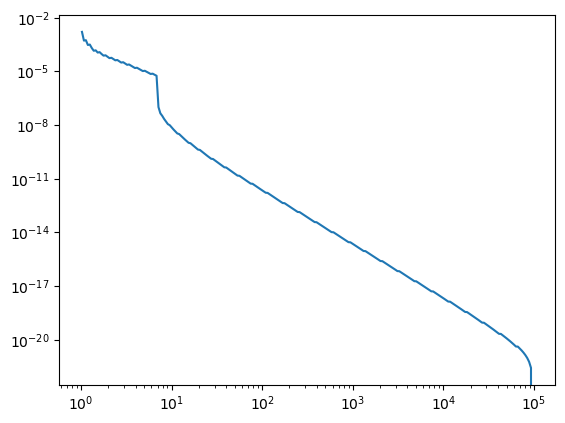

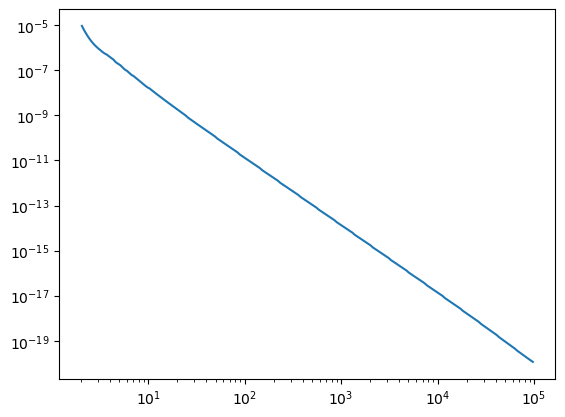

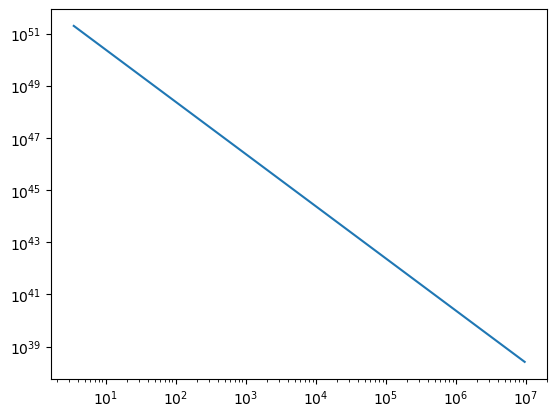

In [97]:
################### This part is Andrew's code with minor modifications from me to put in the proton flux ############
'''
Calculating the resulting chi energy distributions from
    repeated chi scatterings

Here, we consider a very massive vector mediator
'''

import matplotlib
from matplotlib import pyplot as plt
#import scienceplots

#plt.style.use(["science", "ieee", "bright"])
import numpy as np
from numpy import pi as pi
from numpy import sqrt, cos, sin, exp, log
from matplotlib import ticker, cm
import math
import scipy as sp
from scipy import special as spc
from Self_PDF import uPDFfunc, dPDFfunc, Qmin
from numpy.random import randint


def Kallen(a, b, c):
    return (a ** 2 + b ** 2 + c ** 2 - 2 * a * b - 2 * a * c - 2 * b * c)


def sigma0vals(gp_MZ, gChi_MZ, mp, mDM, delta):
    '''
    Code to determine non-relativistic cross section from
    model parameters

    Parameters
    ----------
    gp_MZ : Proton coupling / boson mass [GeV^{-1}]
    gChi_MZ : Dark Matter Coupling / boson mass [GeV^{-1}]
    mp : Mass of proton [GeV]
    mDM : Mass of dark matter ground state [GeV]
    delta : Dark matter mass splitting [GeV]

    Returns
    -------
    sigmaSM0 : Non-relativistic proton-DM scattering [cm^2]
    sigma10 : Non-relativisitic chi_1 + chi_1 -> chi_2 + chi_2 scattering [cm^2]
    sigma20 : Non-relativisitic chi_1 + chi_2 -> chi_1 + chi_2 scattering [cm^2]
    '''
    mu_pDM = (mp * mDM) / (mp + mDM)  # GeV
    mu_11 = (mDM * mDM) / (mDM + mDM)  # GeV
    mu_12 = ((mDM + delta) * mDM) / (2 * mDM + delta)

    ##### set gp_MZ, gChi_MZ to 1 #######
    gp_MZ = 1.0
    gChi_MZ = 1.0

    ## Replaced AG's version with equations that do not have gp_MZ and gChi_MZ
    #sigmaSM0GeV = gp_MZ ** 2 * gChi_MZ ** 2 * mu_pDM ** 2 / pi  # GeV^{-2}
    # sigma10GeV = gChi_MZ ** 4 * mu_11 ** 2 / pi  # GeV^{-2}
    # sigma20GeV = gChi_MZ ** 4 * mu_12 ** 2 / pi  # GeV^{-2}
    sigmaSM0GeV = mu_pDM ** 2 / pi  # GeV^{-2}
    sigma10GeV = mu_11 ** 2 / pi  # GeV^{-2}
    sigma20GeV = mu_12 ** 2 / pi  # GeV^{-2}

    sigmaSM0 = sigmaSM0GeV * (1 / 5.06e13) ** 2  # cm^2 GeV^2
    sigma10 = sigma10GeV * (1 / 5.06e13) ** 2  # cm^2 GeV^2
    sigma20 = sigma20GeV * (1 / 5.06e13) ** 2  # cm^2 GeV^2

    return (sigmaSM0, sigma10, sigma20)


def tplusminus(mSM, mDM, delta, s):
    '''
    Provides maximum/minimum values of Mandelstam
        variable t
    ----------
    mSM : Standard Model particle mass
    mDM : Dark matter mass
    delta : Dark matter mass splitting
    s : Mandelstam variable s

    Returns
    -------
    tplus, tminus: extremum values of t

    '''
    kin_limit = np.heaviside(s - (mDM + delta + mSM) ** 2, 0)
    pisq = 1 / (4 * s) * Kallen(mSM ** 2, mDM ** 2, s)
    # print(pisq)
    pfsq = 1 / (4 * s) * Kallen(mSM ** 2, (mDM + delta) ** 2, s) * kin_limit
    # print(pfsq)
    tplus = mDM ** 2 + (mDM + delta) ** 2 \
            - 2 * (sqrt(mDM ** 2 + pisq) * sqrt((mDM + delta) ** 2 + pfsq) + sqrt(pisq * pfsq)) \
            * kin_limit
    tminus = mDM ** 2 + (mDM + delta) ** 2 \
             - 2 * (sqrt(mDM ** 2 + pisq) * sqrt((mDM + delta) ** 2 + pfsq) - sqrt(pisq * pfsq)) \
             * kin_limit

    return (tplus, tminus)


def dsigmadE2SM(sigma0SM, Ei, E2, mSM, mDM, delta, max_angle=pi):
    '''
    Function for determining the differential cross section
        for SM particles scattering with DM

    Inputs:
        sigma0SM: Cross section of non-relativistic scattering [cm^2]
        Ei: Energy of incoming SM particle [GeV]
        E2: Energy of the outgoing chi_{2} particle [GeV]
        mSM: Mass of the SM particle [GeV]
        mDM: Mass of the chi_{1} particle [GeV]
        delta: Mass splitting of the chi particles [GeV]

    Output:
        dsdE2: Differential Energy Cross Section [cm^{2} GeV^{-1}]
    '''
    s = mSM ** 2 + mDM ** 2 + 2 * mDM * Ei

    tplus, tminus = tplusminus(mSM, mDM, delta, s)
    TDMmin = (delta ** 2 - tminus) / (2 * mDM) * np.heaviside(s - (mSM + mDM + delta) ** 2, 0)
    TDMmax = (delta ** 2 - tplus) / (2 * mDM) * np.heaviside(s - (mSM + mDM + delta) ** 2, 0)

    # print('TDMmin', TDMmin)
    # print('TDMmax', TDMmax)
    TSM = Ei - mSM
    TDM = E2 - mDM
    qsq = 2 * mDM * TDM - delta ** 2
    reducedmass = mDM * mSM / (mDM + mSM)

    Lambda = 0.77  # GeV

    xsq = qsq / Lambda ** 2
    FormFactor = (1 + xsq) ** (-2)

    numerator = mDM * ((s - (mDM ** 2 + mSM ** 2 + delta * mDM)) ** 2 + mDM * TDM * (qsq - 2 * s)) * FormFactor ** 2

    denominator = 2 * reducedmass ** 2 * Kallen(s, mDM ** 2, mSM ** 2)

    dsdE2 = sigma0SM * numerator / denominator * np.heaviside(TDM - TDMmin, 0) * np.heaviside(TDMmax - TDM, 0)

    # Angular Requirements

    cos_theta_num = -delta ** 2 + 2 * mSM * (delta + TDM) + 2 * mDM * TDM + 2 * delta * TSM + 2 * TSM * TDM
    cos_theta_den_sq = 4 * (TSM * (2 * mSM + TSM)) * (TDM * (2 * delta + 2 * mDM + TDM))
    cos_theta = cos_theta_num / sqrt(np.abs(cos_theta_den_sq)) * np.heaviside(cos_theta_den_sq, 0)

    angular_req = np.heaviside(cos_theta - cos(max_angle), 1)

    #Calculate Deep Inelastic Scattering
    #Just use up and down quarks
    #Assume the coupling to quarks is the same as protons
    mq = 0.002 #GeV
    reducedmassq = mDM*mq/(mDM + mq)
    sigma0q = sigma0SM * (reducedmassq / reducedmass)**2
    BjxVals = np.linspace(0.1,1,100)
    dx = BjxVals[1] - BjxVals[0]
    
    dsdE2DIS = np.zeros(dsdE2.shape)
    
    for Bjx in BjxVals:
        
        #print(np.size(qsq))
        fxvals = (uPDFfunc(Bjx,sqrt(np.abs(qsq))) + dPDFfunc(Bjx,sqrt(np.abs(qsq))))\
            * np.transpose([np.heaviside(qsq,0)])
        #print(np.size(fxvals))
        sq = s*Bjx
        tplusq,tminusq = tplusminus(mq,mDM,delta,sq)
        TDMminq = (delta**2 - tminusq)/(2*mDM) * np.heaviside(sq - (mq+mDM+delta)**2,0)
        TDMmaxq = (delta**2 - tplusq)/(2*mDM) * np.heaviside(sq - (mq+mDM+delta)**2,0)
        
        #There is no good reason for this choice here. I need a better threshold
        DISThreshold2 = np.heaviside(sq - 10*mDM**2 - 10*mp**2,0)
        DISThreshold = np.heaviside(qsq - Qmin**2, 0)
        
        numeratorq = mDM * ((sq - (mDM**2 + mq**2 + delta*mDM))**2 + mDM*TDM * (qsq - 2*sq)) * (1-FormFactor**2)
    
        denominatorq = 2 * reducedmassq**2 * Kallen(sq, mDM**2, mq**2)
        
        #print(np.product(np.isfinite(fxvals)))
        try:
            dsdE2DIS += sigma0q*fxvals*dx * numeratorq/denominatorq \
                * np.heaviside(TDM - TDMminq,0)*np.heaviside(TDMmaxq - TDM,0)*DISThreshold*DISThreshold2
        except:
            fxvals = np.transpose(fxvals)
            dsdE2DIS += sigma0q*fxvals*dx * numeratorq/denominatorq \
                * np.heaviside(TDM - TDMminq,0)*np.heaviside(TDMmaxq - TDM,0)\
                    *DISThreshold*DISThreshold2

    
    return ((dsdE2+dsdE2DIS) * angular_req)

    # return ((dsdE2) * angular_req)


def dsigma1dE2(sigma10, Ei, E2, mDM, delta, max_angle=pi):
    '''
    Function for deterimining the differential cross section
        for chi_{1} chi_{1} -> chi_{2} chi_{2} scattering

    Parameters
    ----------
    sigma10 : Cross section of non-relativistic scattering [cm^2]
    Ei : Energy of incoming chi_{1} [GeV]
    E2 : Energy of one of the outgoing chi_{2} [GeV]
    mDM : Mass of chi_{1} particle [GeV]
    delta : Mass splitting [GeV]

    Returns
    -------
    dsdE2: Differential Energy Cross Section [cm^2 GeV^{-1}]
    '''

    s = 2 * mDM ** 2 + 2 * mDM * Ei
    # Kinematic Requirements
    Eth = mDM + 4 * delta + 2 * (delta ** 2) / mDM
    pi = sqrt(Ei ** 2 - mDM ** 2)
    betaCOM = pi / (mDM + Ei)
    gammaCOM = 1 / sqrt(1 - betaCOM ** 2)
    pCOM = sqrt((s / 4 - (mDM + delta) ** 2) * np.heaviside(Ei - Eth, 0))
    ECOM = sqrt(s / 4)
    Emax = gammaCOM * ECOM + gammaCOM * betaCOM * pCOM
    Emin = gammaCOM * ECOM - gammaCOM * betaCOM * pCOM

    kinematic_req = np.heaviside(Ei - Eth, 0) * np.heaviside(Emax - E2, 0) * np.heaviside(E2 - Emin, 0)

    numerator = 4 * (5 * Ei ** 2 * mDM - Ei * (5 * delta ** 2 + 2 * mDM * (E2 + 2 * mDM) + 14 * delta * mDM)
                     + mDM * (2 * E2 ** 2 - 2 * E2 * mDM + (delta + mDM) * (7 * delta + 3 * mDM)))

    dsdE2 = (sigma10 * numerator / (Kallen(s, mDM ** 2, mDM ** 2))) * kinematic_req

    # Angular Requirement

    cos_theta_num = (Ei + mDM) * (E2 - mDM)
    cos_theta_den_sq = (Ei ** 2 - mDM ** 2) * (E2 ** 2 - (mDM + delta) ** 2)
    cos_theta = cos_theta_num / np.sqrt(np.abs(cos_theta_den_sq)) * np.heaviside(cos_theta_den_sq, 0)

    angle_req = np.heaviside(cos_theta - cos(max_angle), 1)

    return (dsdE2 * angle_req)


def sigma1(sigma10, Ei, mDM, delta):
    '''
    Function for the determining the full cross section fo
        chi_{1} chi_{1} -> chi_{2} chi_{2} scattering

    Parameters
    ----------
    sigma10 : Cross section of non-relativistic scattering [cm^2]
    Ei : Energy of incoming chi_{1} [GeV]
    mDM : Mass of chi_{1} particle [GeV]
    delta : Mass splitting [GeV]

    Returns
    -------
    sigma: Cross Section [cm^2]
    '''
    s = 2 * mDM ** 2 + 2 * mDM * Ei
    kinematic_factor = np.heaviside(s - 4 * (mDM + delta) ** 2, 0)
    srt = sqrt(mDM / (Ei + mDM))
    denominator = 3 * mDM ** 3 * sqrt(Ei ** 2 - mDM ** 2)
    prefactor = sqrt((-2 * delta ** 2 + mDM * (Ei - mDM) - 4 * delta * mDM) * kinematic_factor)
    first_term = 17 * Ei ** 2 * mDM * srt
    sec_term = Ei * srt * (10 * mDM ** 2 + 16 * delta **
                           2 + 44 * delta * mDM + 3 * mDM * (Ei + mDM))
    thi_term = mDM * srt * (11 * mDM ** 2 + 22 * delta ** 2 +
                            32 * delta * mDM - 3 * mDM * (Ei + mDM))

    sigma = sigma10 * prefactor * (first_term - sec_term + thi_term) / denominator * np.heaviside(Ei - mDM, 0)
    return (sigma)


def dsigma2dE2(sigma20, Ei, E2, mDM, delta, max_angle=pi):
    '''
    Function for deterimining the differential cross section
        for chi_{1} chi_{2} -> chi_{1} chi_{2} scattering

    Parameters
    ----------
    sigma20 : Cross section of non-relativistic scattering [cm^2]
    Ei : Energy of incoming chi_{1} [GeV]
    E2 : Energy of one of the outgoing chi_{2} [GeV]
    mDM : Mass of chi_{1} particle [GeV]
    delta : Mass splitting [GeV]

    Returns
    -------
    dsdE2: Differential Energy Cross Section [cm^2 GeV^{-1}]
    '''
    s = mDM ** 2 + (mDM + delta) ** 2 + 2 * mDM * Ei
    # Kinematic Requirements
    Eth = mDM + delta

    pi = sqrt((Ei ** 2 - (mDM + delta) ** 2) * np.heaviside(Ei - Eth, 0))
    betaCOM = pi / (mDM + Ei)
    gammaCOM = 1 / sqrt(1 - betaCOM ** 2)
    pCOM = -gammaCOM * betaCOM * Ei + gammaCOM * pi
    ECOM = gammaCOM * Ei - gammaCOM * betaCOM * pi
    Emin = gammaCOM * ECOM - gammaCOM * betaCOM * pCOM

    kinematic_req = np.heaviside(Ei - E2, 0) * np.heaviside(E2 - Emin, 0) * np.heaviside(Ei - Eth, 0)

    prefactor = ((delta + 2 * mDM) / (delta + mDM)) ** 2
    term1 = 2 * Ei ** 2 * mDM
    term2 = Ei * (delta ** 2 - 2 * E2 * mDM + 2 * mDM ** 2 + 2 * delta * mDM)
    term3 = E2 ** 2 * mDM - E2 * (delta + 2 * mDM) ** 2 + 3 * mDM * (delta + mDM) ** 2

    dsdE2 = (sigma20 * prefactor * (term1 + term2 + term3) / \
             Kallen(s, (mDM + delta) ** 2, mDM ** 2)) * kinematic_req

    # Information On Scattering Angle

    cos_theta_num = -delta ** 2 + Ei * E2 - (Ei - E2) * mDM - mDM ** 2 - 2 * delta * mDM
    cos_theta_den_sq = (Ei ** 2 - (mDM + delta) ** 2) * (E2 ** 2 - (mDM + delta) ** 2)
    cos_theta = cos_theta_num / sqrt(np.abs(cos_theta_den_sq)) * np.heaviside(cos_theta_den_sq, 0)

    angle_req = np.heaviside(cos_theta - cos(max_angle), 1)

    return (dsdE2 * angle_req)


def dsigma2dE1(sigma20, Ei, E1, mDM, delta, max_angle=pi):
    '''
    See dsigma2dE2 for notation
    '''
    # Angular Reqirements

    E2 = Ei - E1 + mDM
    cos_theta_num_2 = -delta ** 2 + Ei * E2 - (Ei - E2) * mDM - mDM ** 2 - 2 * delta * mDM
    cos_theta_den_sq_2 = (Ei ** 2 - (mDM + delta) ** 2) * (E2 ** 2 - (mDM + delta) ** 2)
    cos_theta_2 = cos_theta_num_2 / sqrt(np.abs(cos_theta_den_sq_2)) * np.heaviside(cos_theta_den_sq_2, 0)

    sin_theta_2 = sqrt((1 - cos_theta_2 ** 2) * np.heaviside(1 - cos_theta_2 ** 2, 0))
    p1 = sqrt((E1 ** 2 - mDM ** 2) * np.heaviside(E1 ** 2 - mDM ** 2, 0))
    p2 = sqrt((E2 ** 2 - (mDM + delta) ** 2) * np.heaviside(E2 ** 2 - (mDM + delta) ** 2, 0))
    sin_theta_1 = p2 / p1 * sin_theta_2

    cos_theta_1 = np.sqrt(1 - sin_theta_1 ** 2)

    angle_req = np.heaviside(cos_theta_1 - cos(max_angle), 1)

    return (dsigma2dE2(sigma20, Ei, Ei - E1 + mDM, mDM, delta) * angle_req)


def sigma2(sigma20, Ei, mDM, delta):
    '''
    Function for deterimining the cross section
        for chi_{1} chi_{2} -> chi_{1} chi_{2} scattering

    Parameters
    ----------
    sigma20 : Cross section of non-relativistic scattering [cm^2]
    Ei : Energy of incoming chi_{1} [GeV]
    mDM : Mass of chi_{1} particle [GeV]
    delta : Mass splitting [GeV]

    Returns
    -------
    sigma: Cross Section [cm^2]
    '''
    prefactor = (delta + 2 * mDM) ** 2 \
                / (3 * (delta + mDM) ** 2 * (delta ** 2 + 2 * mDM * (Ei + mDM) + 2 * delta * mDM) ** 3)

    term1 = 3 * delta ** 6 + delta ** 4 * \
            (3 * Ei ** 2 + 38 * mDM ** 2) + delta ** 3 * \
            mDM * (3 * Ei ** 2 + 18 * Ei * mDM + 59 * mDM ** 2)
    term2 = delta ** 2 * mDM * (11 * (Ei ** 2) * mDM + 9 * Ei ** 3 + 39 * Ei * mDM ** 2 + 57 * mDM ** 3)
    term3 = 4 * delta * mDM ** 2 * (Ei + mDM) * (3 * Ei ** 2 + Ei * mDM + 8 * mDM ** 2)
    term4 = 4 * mDM ** 2 * (Ei + mDM) ** 2 * (2 * Ei ** 2 - Ei * mDM +
                                              2 * mDM ** 2) - 3 * delta ** 5 * (Ei - 5 * mDM)

    sigma = sigma20 * prefactor * (term1 + term2 + term3 + term4) * np.heaviside(Ei - (mDM + delta), 0)

    return (sigma)


def BlackHoleIntDensity(MBH):
    '''
    Function to determine the integrated number density of dark matter
        around a black hole

    Parameters
    ----------
    MBH : Mass of Black Hole [Solar Mass]

    Returns
    -------
    tot_int_num_dens : column density of dark matter particles
    '''
    c = 3e8  # m s^{-1}
    G = 6.67e-11  # kg^{-1} s^{-2} m^{3}
    Msun = 2e30  # kg

    MBH = 1e8 * Msun  # kg
    Rschw = G * MBH / (c ** 2) * 100  # cm
    Rmin = 4 * Rschw  # cm
    Rmax = 1e5 * Rschw  # cm
    Rchar = 10 * Rschw  # cm (This is chosen arbitrarily)
    rho0 = MBH / (6 * pi * Rchar ** (7 / 3) *
                  (Rmax ** (2 / 3) - Rmin ** (2 / 3)))  # kg cm^{-3}
    rho0 = 5.6e26 * rho0  # GeV cm^{-3}
    tot_integrated_density = (3 / 4) * rho0 * (Rchar ** (7 / 3) /
                                               Rmin ** (4 / 3) - Rchar ** (7 / 3) / Rmax ** (4 / 3))  # GeV cm^{-2}
    tot_int_num_dens = tot_integrated_density / mDM  # cm^{-2}

    return (tot_int_num_dens)


def AGNProtonRate(Gamma_B, alpha_p, cp, mu, ESMvals):
    '''
    Function to calculate Rate of protons

    Parameters
    ----------
    Gamma_B : Boost Factor of Blob
    alpha_p : Power Law behavior in Blob
    cp : Luminosity normalizing constant [s^{-1} sr^{-1}]
    mu: cos(angle) of jet relative to line-of-sight
    ESMvals: Proton energy values [GeV]

    Returns
    -------
    dNSMdESM: Rate of protons produced [GeV s^{-1} sr^{-1}]

    ###TXS cutoffs: 0.2 PeV to 20 PeV
    '''
    Beta_B = np.sqrt(1 - 1 / Gamma_B ** 2)
    TSMvals = ESMvals - mp
    Gamma_p_vals = ESMvals / mp
    Beta_p_vals = sqrt(1 - 1 / Gamma_p_vals ** 2)

    prefactor = 1 / (4 * pi) * (1 + TSMvals / mp) ** (-alpha_p)
    numerator = Gamma_B ** (-alpha_p) * Beta_p_vals * (1 - Beta_B * Beta_p_vals * mu) ** (-alpha_p)
    denominator = np.sqrt((1 - Beta_B * Beta_p_vals * mu) ** 2 - (1 - Beta_p_vals ** 2) * (1 - Beta_B ** 2))
    dNSMdESM = cp * prefactor * numerator / denominator  # GeV^{-1} s^{-1} sr^{-1}

    return (dNSMdESM)


#
def AGNProtonRatecutoff(Gamma_B, alpha_p, cp, mu, ESMvals, lowcut, highcut,alpha_p_low): ###### This is the part that I modified
    '''
    Function to calculate Rate of protons

    Parameters
    ----------
    Gamma_B : Boost Factor of Blob
    alpha_p : Power Law behavior in Blob
    cp : Luminosity normalizing constant [s^{-1} sr^{-1}]
    mu: cos(angle) of jet relative to line-of-sight
    ESMvals: Proton energy values [GeV]

    Returns
    -------
    dNSMdESM: Rate of protons produced [GeV s^{-1} sr^{-1}]

    ###TXS cutoffs: 0.2 PeV to 20 PeV
    '''

    if (ESMvals > lowcut and ESMvals < highcut):
        return (AGNProtonRate(Gamma_B, alpha_p, cp, mu, ESMvals))
    elif (ESMvals < lowcut):
        return (AGNProtonRate(Gamma_B, alpha_p, cp, mu, lowcut)*(ESMvals/lowcut)**(-alpha_p_low))
    else:
        return 0.0



def Chi1Chi2Flux(mDM, delta, gp_MZ, gChi_MZ,alpha_p_low,
                 mu=1, dist=1835.4 * (3.86e24), MBH=1e8, Gamma_B=20, alpha_p=2, cp=2.7e47):
    '''

    Function to determine the fluxes of chi 1 and chi 2 at Earth

    Parameters
    ----------
    mDM : Dark matter ground state mass [GeV]
    delta : Mass splitting [GeV]
    gp_MZ : Proton coupling / boson mass [GeV^{-1}]
    gChi_MZ : Dark Matter Coupling / boson mass [GeV^{-1}]
    mu : cos(angle) of jet relative to line-of-sight. The default is 1.
    dist: distance from black hole to Earth [cm]. Default is 1835.4 Mpc.
    MBH : Mass of Black Hole [Solar Mass]. The default is 1e8.
    Gamma_B :  Boost Factor of Blob. The default is 20.
    alpha_p : Power Law behavior in Blob. The default is 2.
    cp : Luminosity normalizing constant [s^{-1} sr^{-1}]. The default is 2.7e47.

    Returns
    -------
    E1vals : Energies of chi_1 particles [GeV]
    E2vals : Energies of chi_2 particles [GeV]
    dPhidE1vals : Flux of chi_1 particles [GeV^{-1} cm^{-1} s^{-1}] ###### Shouldn't this be cm^{-2}?
    dphidE2vals : Flux of chi_2 particles [GeV^{-1} cm^{-1} s^{-1}] ###### Shouldn't this be cm^{-2}?
    '''
    mp = 0.94  # GeV
    sigmaSM0, sigma10, sigma20 = sigma0vals(gp_MZ,gChi_MZ,mp,mDM,delta)
    print("sigmaSM0", sigmaSM0)
    print("sigma10", sigma10)
    E1thres = (4*(mDM+delta)**2 -2*mDM**2)/(2*mDM)#GeV (E1 energy to scatter)
    Epthres = (delta**2 + 2*mp*mDM + 2*mDM*delta + 2*mp*delta)/(2*mDM)
    
    ESMedges = np.logspace(np.log10(Epthres), 7, 200)  # GeV
    E1edges = np.logspace(np.log10(E1thres), 5, 201)  # GeV
    E2edges = np.logspace(np.log10(mDM + delta), 5, 202)  # GeV
    low_E1_edges = np.logspace(np.log10(mDM),np.log10(E1thres),40)
    ESMvals = np.sqrt(ESMedges[:-1]*ESMedges[1:])
    E1vals = np.sqrt(E1edges[:-1]*E1edges[1:])
    E2vals = np.sqrt(E2edges[:-1]*E2edges[1:])
    low_E1_vals = np.sqrt(low_E1_edges[:-1]*low_E1_edges[1:])
    
    dESM = ESMedges[1:] - ESMedges[:-1]
    dE1 = E1edges[1:] - E1edges[:-1]
    dE2 = E2edges[1:] - E2edges[:-1]
    dE1_low = low_E1_edges[1:] - low_E1_edges[:-1]
    #
    dNSMdESM = np.zeros(len(ESMvals))  # GeV s^{-1} sr^{-1}
    for i in range(len(ESMvals)):
        dNSMdESM[i] = AGNProtonRatecutoff(Gamma_B, alpha_p, cp, mu, ESMvals[i], 0.2*10**6, 2.0 * 10 ** 7,alpha_p_low) #### This has the modified proton information
    #dNSMdESM = AGNProtonRate(Gamma_B, alpha_p, cp, mu, ESMvals)  # GeV s^{-1} sr^{-1}
    dN1dE1 = np.zeros(len(E1vals))  # GeV^{-1} s^{-1} sr^{-1}
    dN2dE2 = np.zeros(len(E2vals))  # GeV^{-1} s^{-1} sr^{-1}
    total_array = np.append(np.append(dN1dE1, dN2dE2), dNSMdESM)

    # tot_int_num_dens = BlackHoleIntDensity(MBH)
    tot_int_num_dens = 1.0*10**(30)/mDM

    sigma_1_vals = sigma1(sigma10, E1vals, mDM, delta)  # cm^2
    sigma_2_vals = sigma2(sigma20, E2vals, mDM, delta)  # cm^2
    dsigma1dE2_vals = np.transpose(dsigma1dE2(sigma10, np.transpose(np.array([E1vals])), E2vals, mDM, delta) \
                                   * np.transpose(np.array([dE1])))
    dsigma2dE1_vals = np.transpose(dsigma2dE1(sigma20, np.transpose(np.array([E2vals])), E1vals, mDM, delta) \
                                   * np.transpose(np.array([dE2])))
    dsigma2dE2_vals = np.transpose(dsigma2dE2(sigma20, np.transpose(np.array([E2vals])), E2vals, mDM, delta) \
                                   * np.transpose(np.array([dE2])))
    dsigmadE2SM_vals = np.transpose(dsigmadE2SM(sigmaSM0, np.transpose(np.array([ESMvals])), E2vals, mp, mDM, delta) \
                                    * np.transpose(np.array([dESM])))

    full_homo_matrix = np.concatenate(
        (np.concatenate((-np.diag(sigma_1_vals), 2 * dsigma1dE2_vals, np.zeros((len(ESMvals), len(E1vals)))), axis=0),
         np.concatenate(
             (dsigma2dE1_vals, -np.diag(sigma_2_vals) + dsigma2dE2_vals, np.zeros((len(ESMvals), len(E2vals)))),
             axis=0),
         np.concatenate(
             (np.zeros((len(E1vals), len(ESMvals))), dsigmadE2SM_vals, np.zeros((len(ESMvals), len(ESMvals)))),
             axis=0)),
        axis=1)

    full_homo_matrix = full_homo_matrix * tot_int_num_dens

    eig_vals, eig_matrix = np.linalg.eig(full_homo_matrix)

    print('Eigen rank', np.linalg.matrix_rank(eig_matrix))

    eig_inv_matrix = np.linalg.inv(eig_matrix)

    # Check that the eigenvalues are correct
    for i in range(len(eig_vals)):
        error = np.matmul(full_homo_matrix, eig_matrix[:, i]) - eig_vals[i] * eig_matrix[:, i]

        if np.abs(np.dot(error, error)) > 0.001:
            print("EigenValue Problem")

    coeffs = np.array([])
    test_array = np.zeros(len(total_array))
    final_array = np.zeros(len(total_array))

    for i in range(len(eig_vals)):
        coeffs = np.append(coeffs, np.dot(total_array, eig_inv_matrix[i, :]))
        test_array += eig_matrix[:, i] * coeffs[i]
        final_array += eig_matrix[:, i] * coeffs[i] * exp(eig_vals[i])

    # low Energy Vals
    dsigma2dE1_vals_low = np.transpose(dsigma2dE1(sigma20, np.transpose(np.array([E2vals])), low_E1_vals, mDM, delta) \
                                       * np.transpose(np.array([dE2])))
    low_matrix = np.concatenate((np.zeros((len(low_E1_vals), len(E1vals))),
                                 dsigma2dE1_vals_low, np.zeros((len(low_E1_vals), len(ESMvals)))), axis=1)

    low_matrix = low_matrix * tot_int_num_dens

    low_final_array = np.zeros(len(low_E1_vals))

    for i in range(len(eig_vals)):
        if eig_vals[i] == 0:
            low_final_array += np.matmul(low_matrix, eig_matrix[:, i]) * coeffs[i]
        else:
            low_final_array += np.matmul(low_matrix, eig_matrix[:, i]) * coeffs[i] \
                               * (1 / eig_vals[i]) * (exp(eig_vals[i]) - 1)

    eig_dN1dE1 = final_array[0:len(dN1dE1)]
    eig_dN2dE2 = final_array[len(dN1dE1):len(dN1dE1) + len(dN2dE2)]

    E1vals = np.append(low_E1_vals, E1vals)
    dN1dE1 = np.append(low_final_array, eig_dN1dE1)

    dPhi1dE1 = dN1dE1 / dist ** 2
    dPhi2dE2 = eig_dN2dE2 / dist ** 2

    return (E1vals, E2vals, ESMvals, dPhi1dE1, dPhi2dE2,dNSMdESM)


# MODEL Parameters
mDM = 1  # GeV
delta = 1  # GeV
mp = 0.94  # GeV
gp_MZ = 1e-3  # GeV^{-1}
#gp_MZ = 1  # GeV^{-1}
gChi_MZ = 1  # GeV^{-1}
#sigma=gp_MZ**2*gChi_MZ**2/(4*pi*)

E1vals, E2vals, ESMvals, dPhi1dE1, dPhi2dE2,dNSMdESM = Chi1Chi2Flux(mDM, delta, gp_MZ, gChi_MZ,2) ##### Calling the function with the modified proton information

fig = plt.figure()
plt.plot(E1vals, [(gChi_MZ*gp_MZ)**2*elem for elem in dPhi1dE1])
plt.xscale('log')
plt.yscale('log')

fig = plt.figure()
plt.plot(E2vals, [(gChi_MZ*gp_MZ)**2*elem for elem in dPhi2dE2])
plt.xscale('log')
plt.yscale('log')
plt.show()

fig = plt.figure()
plt.plot(ESMvals, dNSMdESM)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [48]:
###### This code blocks calculates the differential event rate dR/dE_t ######

def drdEt(mt,et,mchi1,delta,gchign,ma,a,dphichi1dE,dphichi2dE): 
    '''
    Function to determine the differential event rate (per unit detector mass) from the incoming DM flux at the terrestrial detector as a function of recoil energy E_t

    Parameters
    ----------
    mt : Mass of target nucleus [GeV]
    tchimin : Minimum value of tchi [GeV^2]
    tchimax : Maximum value of tchi [GeV^2]

    Returns
    -------
    dRdEvals : Differential event rate [s^{-1} GeV^{-2}] change units

    '''
    mchi2=mchi1+delta

    tchiminchi1,tchimaxchi1 = tchilims(mt,et,delta,mchi1),100
    tchiminchi2,tchimaxchi2 = tchilims(mt,et,delta,mchi2),100
    integralchi1 = integrate.quad(lambda tchi: dphichi1dE(tchi)*dsigmachi1dE(mt,et,mchi1,delta,gchign,tchi,ma,a),tchiminchi1,tchimaxchi1)[0]
    integralchi2 = integrate.quad(lambda tchi: dphichi2dE(tchi)*dsigmachi2dE(mt,et,mchi1,delta,gchign,tchi,ma,a),tchiminchi2,tchimaxchi2)[0]
    #
    return (1.0/mt)*integralchi1,(1/mt)*integralchi2
    
#
def tchilims(mt,et,delta,mchi):
    '''
    Function to determine the limits of tchi for the integration

    Returns
    -------
    tchimin : Minimum value of tchi [GeV^2]
    tchimax : Maximum value of tchi [GeV^2]

    '''
    const1=0.5*et*mt-delta/4.0*(2*mchi+delta)-mchi
    term2num=math.sqrt(et*(et+2*mt)*(2*et*mt+delta**2)*(2*mt*et+(2*mchi+delta)**2))
    term2denom= 4.0*mt*et
    #
    # return const1-(term2num/term2denom),const1+(term2num/term2denom)
    return const1+(term2num/term2denom)
#
def dsigmachi1dE(mt,et,mchi1,delta,gchign,tchi,ma,a):
    '''
    Function to determine the differential cross section for chi1 scattering

    Input:
    mt : Mass of target nucleus [GeV] = 131 GeV
    et : Recoil energy of the target nuclei [GeV]
    mchi1 : Mass of chi1 particle [GeV]
    gchign : Coupling of chi1 to nucleus
    tchi : Kinetic energy of chi1 [GeV]
    ma : Mass of each nuclei [GeV] = 1 GeV
    a : Mass number of the target nuclei = 131

    Returns
    -------
    dsigmachi1dE : Differential cross section [cm^2 GeV^{-1}]
    '''
    gchign=1.0
    convcrossec=0.389*10**(-35) #### to convert to cm^2 GeV^-1
    numer=2*mt*et**2-et*(2*(mt+mchi1)**2+4*mt*tchi+2*mchi1*delta+delta**2)+mt*(4*(mchi1+tchi)**2-delta**2)
    denom=2*math.pi*(ma**2+2*mt*et)**2*(tchi**2+2*mchi1*tchi)
    #
    return convcrossec*(a*gchign)**2*formfac(mt,et)*(numer/denom)
#
def dsigmachi2dE(mt,et,mchi1,delta,gchign,tchi,ma,a):
    '''
    Function to determine the differential cross section for chi2 scattering

    Input:
    mt : Mass of target nucleus [GeV] = 131 GeV/c^2
    et : Recoil energy of the target nuclei [GeV]
    mchi1 : Mass of chi1 particle [GeV]
    gchign : Coupling of chi1 to nucleus
    tchi : Kinetic energy of chi2 [GeV]
    ma : Mass of each nuclei [GeV] = 1 GeV/c^2
    a : Mass number of the target nuclei = 131

    Returns
    -------
    dsigmachi2dE : Differential cross section [cm^2 GeV^{-1}]
    '''
    gchign=1.0
    convcrossec=0.389*10**(-35) #### to convert to cm^2 GeV^-1
    numer=2*mt*et**2-et*(2*(mt+mchi1)**2+4*mt*tchi+4*mt*delta-delta**2)+mt*(4*(mchi1+tchi)**2+6*(mchi1+tchi)+delta**2)
    denom=2*math.pi*(ma**2+2*mt*et)**2*(tchi**2+2*(mchi1+delta)*tchi)
    #
    return convcrossec*(a*gchign)**2*formfac(a,et)*(numer/denom)
#
def formfac(A, E_R):
    """
    Calculate the form factor given an recoil energy and atomic mass number using the Helm parameterisation. 

    Input: 
    - E_R Recoil Energy in GeV
    - A: Atomic mass number 

    Output: 
    - Form Factor
    """
    m = 0.9315*A # GeV 
    s = 0.9 # fm
    a = 0.52 # fm
    c = 1.23*A**(1/3) - 0.60 # fm
    R1 = np.sqrt(c**2 + 7/3 * np.pi**2 *a**2 - 5*s**2) # fm

    # Transform to natural units
    R1_NU = R1/0.1975 # GeV^-1
    s_NU = s/0.1975 # GeV^-1
    q = np.sqrt(2*m*E_R) # GeV

    j_n = special.spherical_jn(1,q*R1_NU)

    return(3*j_n/(q*R1_NU))**2 * np.exp(-q**2 *s_NU**2)
#
# def formfac(mt,et):
#     C = 770*1e-3 ##GeV
#     return 1/(1+(2*mt*et)**2/(C**2))**2

-0.0

In [98]:
conv=0.176*10**(32) #### to convert to tonne^-1 yr^-1 keV^-1
etlist=np.logspace(-6,math.log10(100*10**(-6)),100)
#
mDM = 1  # GeV
delta = 1  # GeV
gp_MZ = 1e-3  # GeV^{-1}
gChi_MZ = 1  # GeV^{-1}
#
drdetchi1delplist=[]
drdetchi2delp1list=[]
for i in range(len(etlist)):
    E1vals, E2vals, ESMvals, dPhi1dE1, dPhi2dE2,dNSMdESM = Chi1Chi2Flux(mDM, delta, 1.0, 1.0,2.0)
    #print(max(dPhi1dE1))
    dPhi1dE1func=interp1d(E1vals,dPhi1dE1)
    dPhi2dE2func=interp1d(E2vals,dPhi2dE2)
    drdetchi1,drdetchi2=drdEt(131,etlist[i],mDM,delta,1.0,1,131,dPhi1dE1func,dPhi2dE2func) ###drdEt(mt,et,mchi1,delta,gchign,ma,a,dphichi1dE,dphichi2dE): 
    drdetchi1delplist.append((gChi_MZ*gp_MZ)**4*conv*(drdetchi1))     
    drdetchi2delp1list.append((gChi_MZ*gp_MZ)**4*conv*(drdetchi2))
    #
    etlist[i]=etlist[i]*10**6

sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
sigmaSM0 2.9

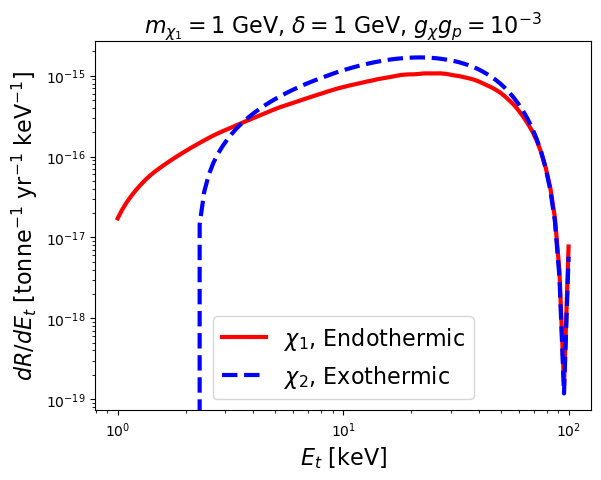

In [99]:
# plt.loglog(etlist,drdetlistdelp0001,label=r'$\delta = 0.0001$',color='midnightblue')
# plt.loglog(etlist,drdetlistdelp001,label=r'$\delta = 0.001$',color='orange')
# plt.loglog(etlist,drdetlistdelp01,label=r'$\delta = 0.01$',color='green')
plt.loglog(etlist,drdetchi1delplist,label=r'$\chi_1$, Endothermic',linestyle='-',color='red',linewidth=3.0)
plt.loglog(etlist,drdetchi2delp1list,label=r'$\chi_2$, Exothermic',linestyle='--',color='blue',linewidth=3.0)
#
#plt.xlim(10**0,10**3)
#plt.ylim(10**-5,10**-2)
plt.xlabel(r'$E_t$ [keV]',fontsize=16)
plt.ylabel(r'$dR/dE_t$ [tonne$^{-1}$ yr$^{-1}$ keV$^{-1}$]',fontsize=16)
plt.title(r'$m_{\chi_1} = 1$ GeV, $\delta = 1$ GeV, $g_\chi g_p = 10^{-3}$',fontsize=16)
plt.legend(loc='best',fontsize=16)

In [51]:
###### Efficiency for XENON-nT ######
#
efficiency_txt = pd.read_csv('efficiency.txt', header=None)
efficiency_txt.columns = ["energy", "a", "b", "eff", "c", "d"]
energy_kev = list(efficiency_txt.energy)
eff = list(efficiency_txt.eff)
eff_ext = interp1d(energy_kev, eff, fill_value="extrapolate")

In [112]:
def events(mt,mchi,delta,gchign,ma,a):
    elowlim=1*10**(-6) ##GeV
    euplim=70*10**(-6) ##GeV
    gchign=1.0
    #
    expose=1.6 ##tonne yr
    #
    E1vals, E2vals, ESMvals, dPhi1dE1, dPhi2dE2,dNSMdESM = Chi1Chi2Flux(mDM, delta, 1.0, 1.0,-1)
    dPhi1dE1func=interp1d(E1vals,dPhi1dE1)
    dPhi2dE2func=interp1d(E2vals,dPhi2dE2)
    #print(max(dPhi1dE1))
    #
    #
    valforchi1=integrate.quad(lambda et: (conv/10**(-6))*drdEt(mt,et,mchi,delta,1.0,ma,a,dPhi1dE1func,dPhi2dE2func)[0]*eff_ext(et)*expose,elowlim,euplim)[0] #### conv is to convert to tonne^-1 yr^-1 keV^-1 but here we need it in GeV^-1
    #valforchi2=integrate.quad(lambda et: conv*drdEt(mt,et*10**(-6),mchi+delta,delta,1,ma,a)*eff_ext(et)*expose,elowlim,euplim)[0]
    return valforchi1

In [113]:
gchignlist=np.logspace(-3,3,1000)
mchilist=np.logspace(-3,3,100)
#
nsig=5.32 ##number of signal events at 90% CL
#
gchignvallist=[]
for i in range(0,len(mchilist)):
    print('Running for mchi = ',mchilist[i])
    check=0
    eventsmchi=events(131,mchilist[i],1,1.0,1,131)
    for j in range(0,len(gchignlist)):
        #print('Running for gchign = ',gchignlist[j])
        if((gchignlist[j])**4*eventsmchi>nsig):
            check=1
            gchignvallist.append(gchignlist[j])
            print(mchilist[i],gchignlist[j])
            break
    if(check==0):
        gchignvallist.append(0.0)

Running for mchi =  0.001
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
0.001 54.04216420705915
Running for mchi =  0.0011497569953977356
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
0.0011497569953977356 54.04216420705915
Running for mchi =  0.0013219411484660286
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
0.0013219411484660286 54.04216420705915
Running for mchi =  0.0015199110829529332
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
0.0015199110829529332 54.04216420705915
Running for mchi =  0.001747528400007683
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
0.001747528400007683 54.04216420705915
Running for mchi =  0.002009233002565048
sigmaSM0 2.918779860460431e-29
sigma10 3.108057911619759e-29
Eigen rank 530
0.002009233002565048 54.04216420705915
Running for mchi =  0.0023101297000831605
sigmaSM0 2.918779860460431e-29
sigma10 3.10805

Text(0, 0.5, '$g_\\chi g_p$')

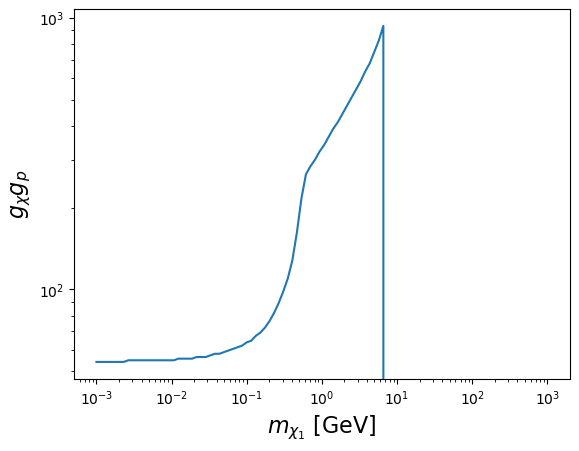

In [114]:
plt.loglog(mchilist,gchignvallist)
plt.xlabel(r'$m_{\chi_1}$ [GeV]',fontsize=16)
plt.ylabel(r'$g_\chi g_p$',fontsize=16)

In [43]:
drdEt(131,1,1,1,1.0,1,131,dPhi1dE1func,dPhi2dE2func)[1]

0.0

In [61]:
mchilist

array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ])

In [78]:
gchignvallist

[4.014242490499322,
 5.054796821191241,
 8.316104153230961,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]